In [160]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [122]:
import numpy as np
import pandas as pd

In [123]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [124]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [125]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [126]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [127]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [128]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station


In [129]:
# Create our session (link) from Python to the DB
session=Session(engine)

# Exploratory Climate Analysis

In [130]:
#get column information (station)
first_row_station = session.query(station).first()
first_row_station.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x120aa8bd0>,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'elevation': 3.0,
 'id': 1,
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168}

In [131]:
#get column info (measurement)
first_row_measure = session.query(measurement).first()
first_row_measure.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x120aed390>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'prcp': 0.08,
 'id': 1,
 'station': 'USC00519397'}

('2017-08-23',)
Query Date:  2016-08-23
Index(['2016-08-24', '2016-08-24', '2016-08-24', '2016-08-24', '2016-08-24',
       '2016-08-24', '2016-08-24', '2016-08-25', '2016-08-25', '2016-08-25',
       ...
       '2017-08-21', '2017-08-21', '2017-08-21', '2017-08-22', '2017-08-22',
       '2017-08-22', '2017-08-23', '2017-08-23', '2017-08-23', '2017-08-23'],
      dtype='object', name='Date', length=2223)


Text(0, 0.5, 'Percipitation (mm)')

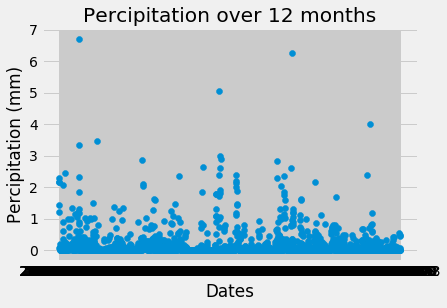

In [183]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date=session.query(measurement.date).order_by(measurement.date.desc()).first()
print(last_date)

# 1 year before last date is query_date 
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("Query Date: ", query_date)

# Perform a query to retrieve the data and precipitation scores
twelvemonth = session.query(measurement.prcp, measurement.date).\
    filter(measurement.date > query_date).\
    order_by(measurement.date).statement
twelvemonth

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.read_sql_query(twelvemonth, conn)
df=df.rename(columns={'date':'Date',
                  'prcp':'Percipitation'})
df=df.set_index('Date')

# Sort the dataframe by date
date_df=df.sort_values('Date')
print(date_df.index)

# Use Pandas Plotting with Matplotlib to plot the data
x_axis = date_df.index
y_axis =date_df.Percipitation

#format months
months = mdates.MonthLocator() 
years_fmt = mdates.DateFormatter('%Y')

plt.scatter(x_axis,y_axis)
plt.title('Percipitation over 12 months')
plt.xlabel('Dates')
plt.ylabel('Percipitation (mm)')

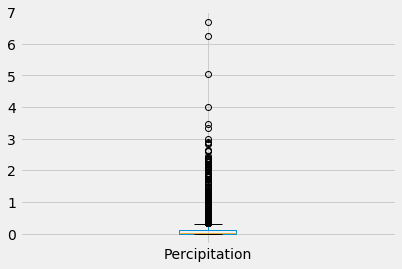

In [196]:
# Use Pandas to calcualte the summary statistics for the precipitation data
date_df.boxplot('Percipitation')


In [ ]:
# Design a query to show how many stations are available in this dataset?


In [ ]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.


In [ ]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?


In [ ]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
